In [19]:
import torch
import numpy as np
from sys import exit
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot
from torch.utils.data import Dataset, DataLoader

In [20]:
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

In [21]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [22]:
%ls gdrive/MyDrive

'Colab Notebooks'/  'DR Principles'@   images.npy
'DR Company'@       'DR Teams'@        week_inc.npy


In [23]:
num_epochs = 200

# select target data
target_file = 'week_inc.npy'
plot_title = '1 Week Up/Down'
# gap = 1     # day
gap = 5     # week
# gap = 21    # month

# regularization
drop_p = .02    # dropout percentage
lamb = 1e-5     # L2 constant

In [27]:
# load data
raw_img_arr = np.load('gdrive/MyDrive/images.npy')[:-gap]
target_arr = np.load('gdrive/MyDrive/' + target_file)
pct = np.mean(target_arr)
bench = max(pct, 1 - pct)
# print(raw_img_arr.shape)
# print(target_arr.shape, '\n')

# normalize
mean = raw_img_arr.mean(axis=(0,1,2))
std = raw_img_arr.std(axis=(0,1,2))
img_arr = (raw_img_arr - mean) / std

# save as tensors
img_ten = torch.Tensor(img_arr).permute(0, 3, 1, 2)    # hwc to chw
target_ten = torch.Tensor(target_arr)
# print(img_ten.shape)
# print(target_ten.shape, '\n')

# one-hot encode classes
target_classes = one_hot(target_ten.to(torch.int64), 2).to(torch.float)
# print(target_classes.shape, '\n')

# split into train/validation
train_imgs = img_ten[:1224-gap]
train_target = target_classes[:1224-gap]
val_imgs = img_ten[1224:]
val_target = target_classes[1224:]
# print(train_imgs.shape)
# print(train_target.shape)
# print(val_imgs.shape)
# print(val_target.shape)

# Dataset class
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# save tensors as Datasets
train_dataset = MyDataset(train_imgs, train_target)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, pin_memory=True)
val_dataset = MyDataset(val_imgs, val_target)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [29]:
class CNN(nn.Module):
    def __init__(self, drop_p):
        
        # initialize
        super().__init__()
        c = 2
        output = 2
        
        # layers
        self.net = nn.Sequential(                                   # 2x256x256
            nn.Conv2d(c, 8, kernel_size=3, stride=1, padding=1),    # 8x256x256
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),    # 8x256x256
            nn.ReLU(),                                              # 8x256x256
            nn.MaxPool2d(4),                                        # 8x64x64
            nn.Dropout(drop_p),                                     # 8x64x64
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),   # 16x64x64
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),  # 16x64x64
            nn.ReLU(),                                              # 16x64x64
            nn.MaxPool2d(4),                                        # 16x16x16
            nn.Dropout(drop_p),                                     # 16x16x16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 32x16x16
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 32x16x16
            nn.ReLU(),                                              # 32x16x16
            nn.MaxPool2d(4),                                        # 32x4x4
            nn.Dropout(drop_p),                                     # 32x4x4
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64x4x4
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 64x4x4
            nn.ReLU(),                                              # 64x4x4
            nn.MaxPool2d(4),                                        # 64x1x1
            nn.Flatten(),                                           # 64
            nn.Linear(64, 16),                                      # 16
            nn.ReLU(),                                              # 16
            nn.Linear(16, output),                                  # 2
            nn.Softmax(1)                                           # 2
        )
    
    def forward(self, x):
        return self.net(x).squeeze()

In [30]:
# GPU
device = torch.device('cuda')

# initialize model
model = CNN(drop_p)
model.to(device)

# initialize objective and optimizer
objective = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), weight_decay=lamb)

# initialize
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# epoch
for epoch in range(num_epochs):
    
    # batch
    temp_train_loss = []
    temp_train_acc = []
    for batch, (x, y_truth) in enumerate(train_loader):
        # samples
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        
        # zero gradients
        optimizer.zero_grad()
               
        # backward
        loss = objective(y_hat, y_truth)
        loss.backward()
        
        # save error and accuracy
        temp_train_loss.append(loss.item())
        guess = torch.argmax(y_hat, axis=1)
        acc = torch.mean(torch.abs(guess - y_truth[:,0]))
        temp_train_acc.append(acc.item())

        # step
        optimizer.step()

    # save error and accuracy
    train_loss.append(np.array(temp_train_loss).mean())
    train_acc.append(np.array(temp_train_acc).mean())
        
    # validate
    temp_val_loss = []
    temp_val_acc = []
    for val_x, val_y in val_loader:
        # samples
        val_x, val_y = val_x.to(device), val_y.to(device)
        y_hat = model(val_x)
        
        # save error and accuracy
        temp_val_loss.append(objective(y_hat, val_y).item())
        guess = torch.argmax(y_hat, axis=1)
        acc = torch.mean(torch.abs(guess - val_y[:,0]))
        temp_val_acc.append(acc.item())
    val_loss.append(np.array(temp_val_loss).mean())
    val_acc.append(np.array(temp_val_acc).mean())

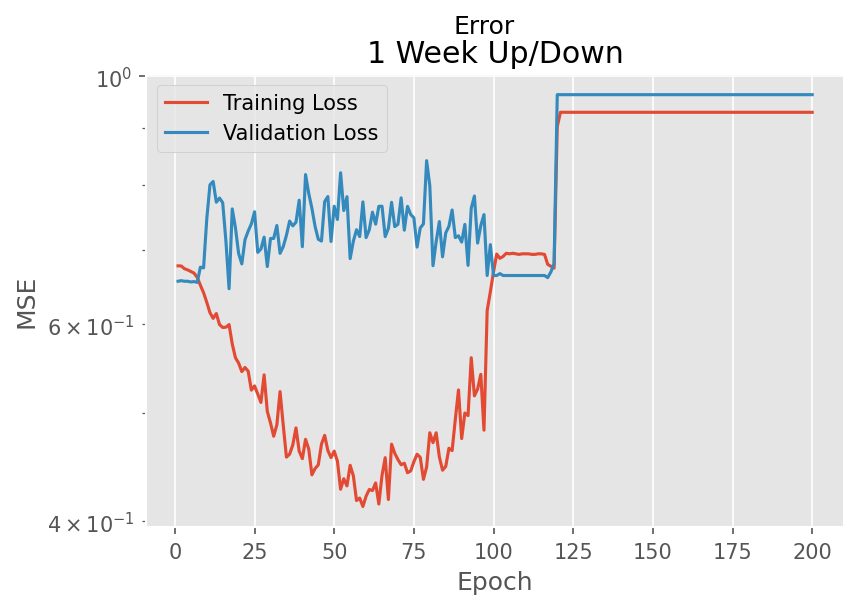

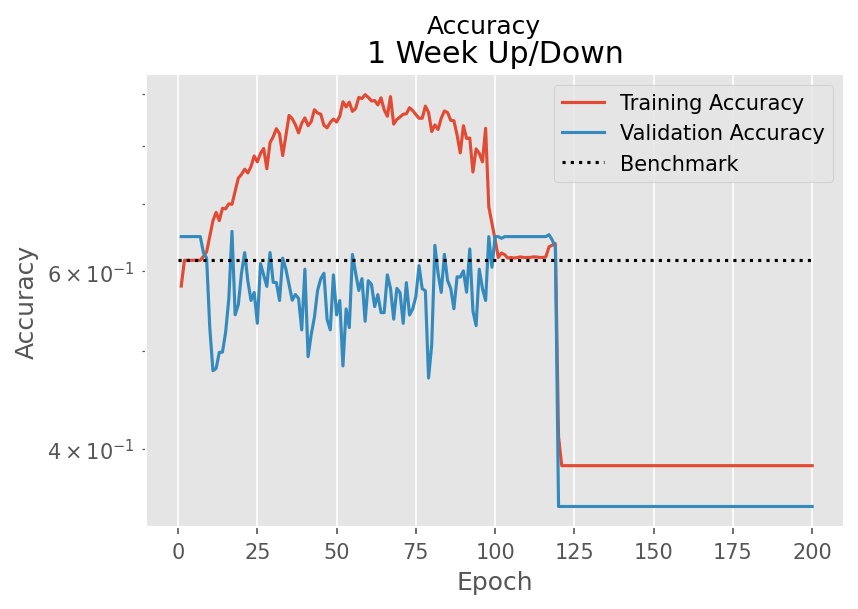

In [31]:
# plot loss
epoch_range = np.arange(1, num_epochs + 1)
plt.title(plot_title)
plt.suptitle('Error')
plt.semilogy(epoch_range, train_loss, label='Training Loss')
plt.semilogy(epoch_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# plot Accuracy
plt.title(plot_title)
plt.suptitle('Accuracy')
plt.semilogy(epoch_range, train_acc, label='Training Accuracy')
plt.semilogy(epoch_range, val_acc, label='Validation Accuracy')
plt.semilogy([0, num_epochs], [bench, bench], 'k:', label='Benchmark')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()